# Introduccion

In [48]:
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
# pmdarima
# !pip install pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

In [49]:
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


In [50]:
# skforecast
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings

## Descarga de datos.

In [51]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
 'master/data/consumos-combustibles-mensual.csv')
datos_t = pd.read_csv(url, sep=',')
datos_t = datos_t[['Fecha', 'Gasolinas']]
datos_t = datos_t.rename(columns={'Fecha':'date', 'Gasolinas':'litters'})
datos_t['date'] = pd.to_datetime(datos_t['date'], format='%Y-%m-%d')
datos_t = datos_t.set_index('date')
datos = datos_t.loc[:'1980-01-01 00:00:00']
datos = datos.asfreq('MS')
datos = datos['litters']
datos.head()

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

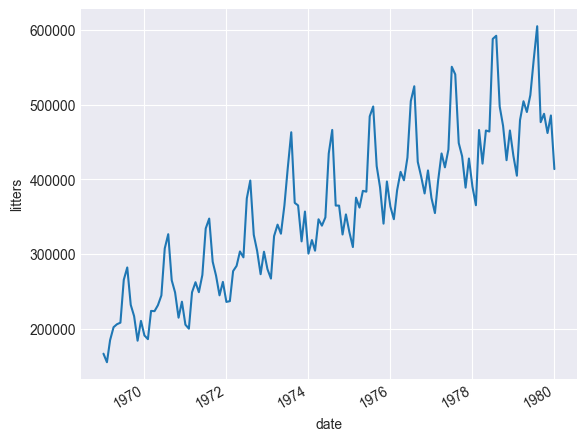

In [52]:
sns.lineplot(datos)
plt.xticks(rotation=30, ha='right')
plt.show()

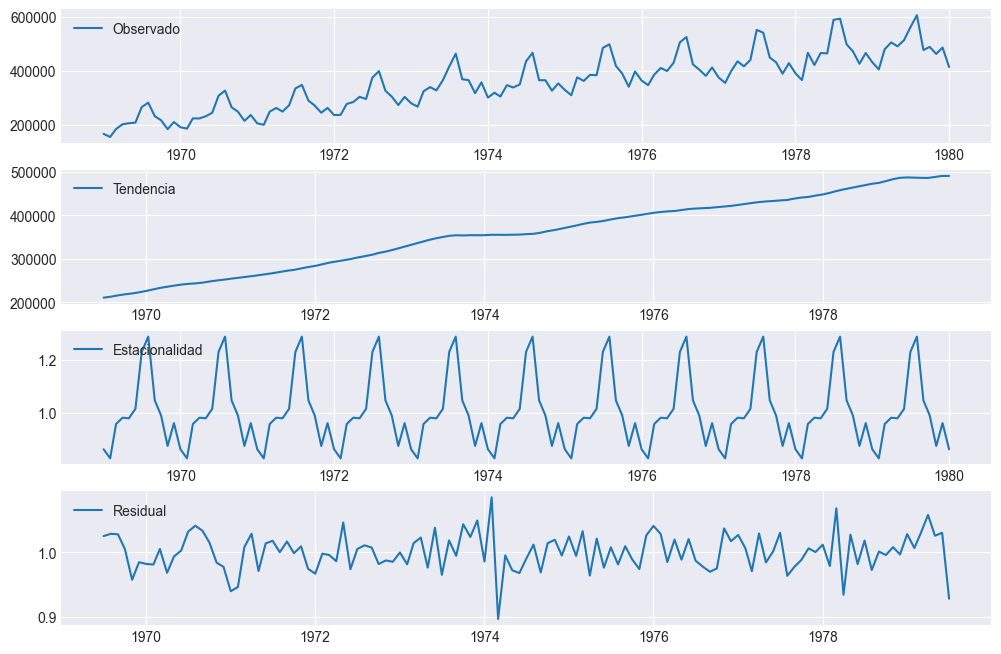

In [53]:
decompose = seasonal_decompose(datos, model="multiplicative")

#represenatcion
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decompose.observed, label='Observado')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(decompose.trend, label='Tendencia')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(decompose.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(decompose.resid, label='Residual')
plt.legend(loc='upper left')

plt.show()

In [61]:
decompose.seasonal[:14]

date
1969-01-01    0.860609
1969-02-01    0.826162
1969-03-01    0.956248
1969-04-01    0.980291
1969-05-01    0.977983
1969-06-01    1.013878
1969-07-01    1.229699
1969-08-01    1.287675
1969-09-01    1.045872
1969-10-01    0.988698
1969-11-01    0.873217
1969-12-01    0.959669
1970-01-01    0.860609
1970-02-01    0.826162
Freq: MS, Name: seasonal, dtype: float64

## Estacionaridad de la varianza
Para quitar la influencia de la tendencia tenemos que restar a cada dato de nuestra colleccion el valor dato anterior. 

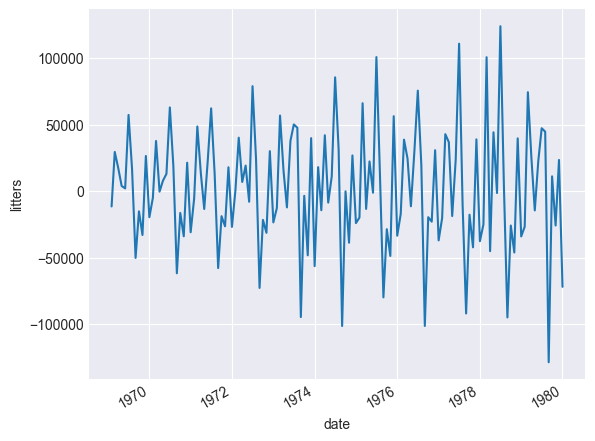

In [54]:
datos_diff = datos.diff()
sns.lineplot(datos_diff)
plt.xticks(rotation=30, ha="right")
datos_diff = datos_diff.dropna()
plt.show()

Como se puede ver en la imagen, la varianza se va incrementando.

## Estacionaridad de la tendencia
Para quitar la influenca de la varianza en nuestros datos, tenemos que aplicar un logaritmo a todos los datos. Así, si nuestros datos tienen heterocedasticidad no se verá reflejado en nuestros datos. Si tienen homocedasticidad, no hace falta hacerlo

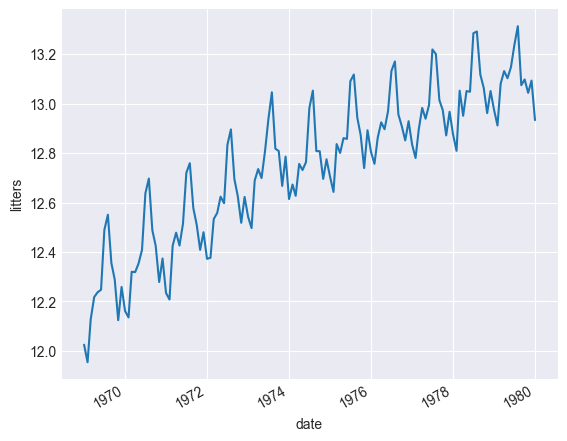

In [55]:
datos_log = np.log(datos)
sns.lineplot(datos_log)
plt.xticks(rotation=30, ha="right")
plt.show()

# ARIMA estacional

## Referente a la parte ARIMA no estacional. (p,d,q)
a. Hemos visto que no es estacionaria en tendencia, por lo que debemos diferenciarlo hasta que lo sea

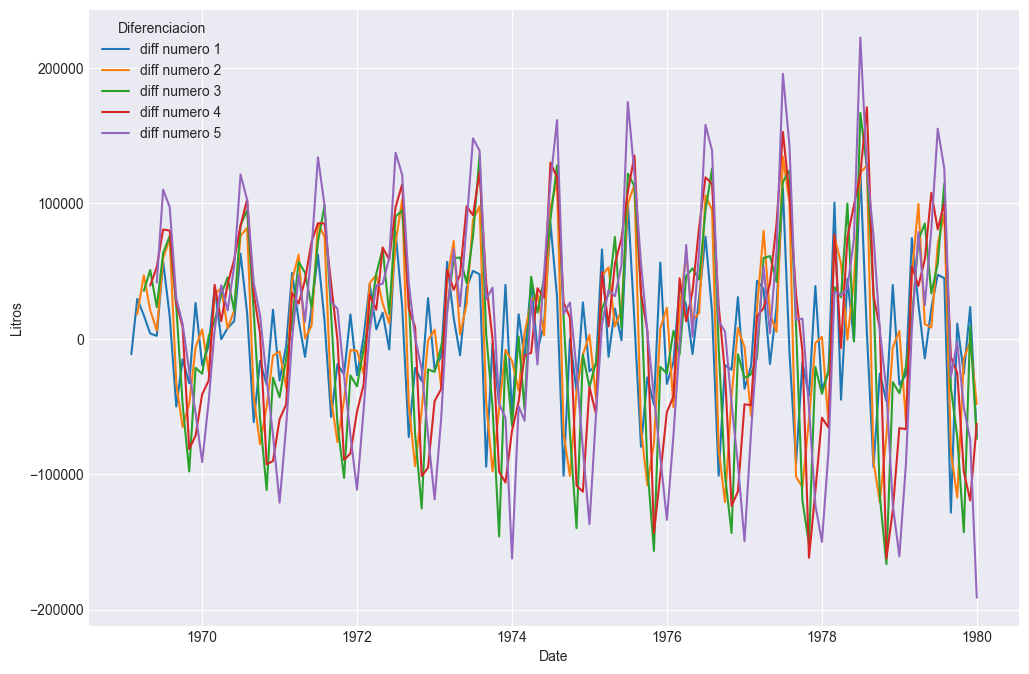

In [56]:
plt.figure(figsize=(12,8))

for i in range(1, 6):
    datos_plot =  datos.diff(i)
    plt.plot(datos.index, datos_plot, label=f"diff numero {i}")

plt.legend(title='Diferenciacion')
plt.xlabel('Date')
plt.ylabel('Litros')
# Mostrar el gráfico
plt.show()


b. Hacemos los autocorrelogramas

In [57]:
datos_diff

date
1969-02-01    -11408.4024
1969-03-01     29516.8594
1969-04-01     17336.1465
1969-05-01      3939.3359
1969-06-01      2152.6856
                 ...     
1979-09-01   -128395.4980
1979-10-01     11202.5058
1979-11-01    -25740.6347
1979-12-01     23507.4902
1980-01-01    -71760.6159
Freq: MS, Name: litters, Length: 132, dtype: float64

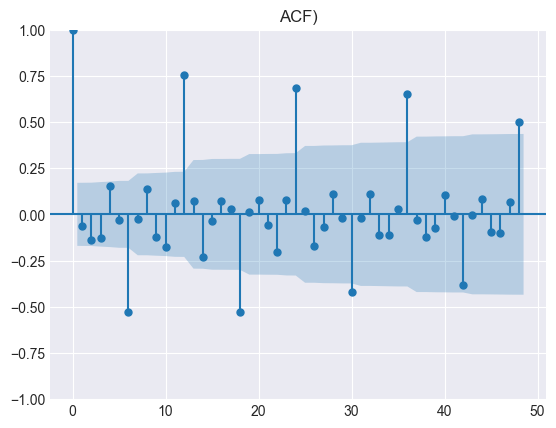

In [ ]:
plot_acf(datos_diff, lags=48, alpha = 0.05)
plt.title('ACF')
plt.show()


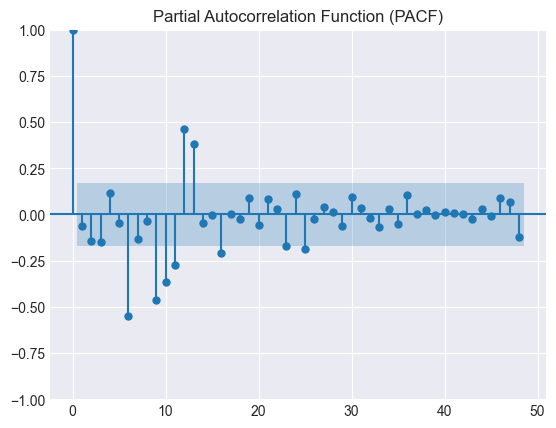

In [59]:
plot_pacf(datos_diff, lags=48, alpha = 0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


Como solo tenemos la primera (que es el valor propio) usaremos p = 0

## Referente a la parte ARIMA estacional $(P,D,Q)_{12}$